In [1]:
# Set the project working directory
import sys
import os
pwd = os.path.abspath('../')
sys.path.insert(0, pwd)

# Import dataset and client modules
from src.ppi_data import PPIData
from src.open_targets.bigquery_fetcher import BigQueryClient, direct_scores, indirect_scores
from src.open_targets.graphql_fetcher import GraphQLClient

# Import graph creation and visualization
from src.bigraph import BiGraph

# Import edge-related feature engineering functions
from src.edge_utils import *

# Import embedding models
from src.embeddings import Node2Vec, ProNE, GGVec, EmbeddingGenerator

# Import model selection functions
from src.ml_models import *
from src.model_evaluation import ModelEvaluation
import joblib

# Import prediction functions
from src.edge_predictions import *

In [2]:
# ---------------------------------------------------------------------------
# MAIN CONFIGURATION: (IDEALLY THIS SHOULD BE READ FROM A CONFIGURATION FILE)
# ---------------------------------------------------------------------------

# Set disease EFO-ID
disease_id = 'MONDO_0008903' # lung cancer
# disease_id = 'EFO_0000319' # cardiovascular
params = {'disease_id': disease_id}

# Path to BigQuery credentials (if using BigQuery data)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = pwd + "/src/open_targets/stemaway-d5a18133ff83.json"

# Maximum number of protein-protein interactions (PPI)
max_ppi_interactions = 5000000

# Set ratio of negative to positive samples for classification
negative_to_positive_ratio = 10

# Define data source (can be direct, indirect, or global scores)
data_source = "GraphQL_global_scores"  # Options: "BigQuery_indirect_scores", "GraphQL_global_scores", "BigQuery_direct_scores"

# Specify train/test split ratio for model validation
test_size = 0.2

# Specify whether to split edges for later prediction
split_edges = True

# Define embedding method (options include various node embedding algorithms)
embedding_mode = "Node2Vec"  # Options: 'Node2Vec', 'ProNE', 'GGVec', 'simple_node_embedding'

# Set model selection for classification
model_name = "Logistic_Regression"  # Options: 'Random_Forest', 'Gradient_Boosting', 'SVM', 'Logistic_Regression'

# Define output directory for models, edges, and embeddings
output_dir = pwd + '/results/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [3]:
# ---------------------
# DATA PROCESSING
# ---------------------

# 1. Load and process PPI data
ppi_data = PPIData(max_ppi_interactions=max_ppi_interactions)
ppi_df = ppi_data.process_ppi_data()
ppi_df.head()

Final PPI data shape: (5000000, 3)


,GeneName1,GeneName2,combined_score
0,ESPL1,PTTG1,0.999
1,TP53,MDM2,0.999
2,PRPF3,PRPF4,0.999
3,CDKN1B,SKP2,0.999
4,MLST8,MTOR,0.999


In [4]:
# 2. Fetch data based on the selected data source

if data_source == "GraphQL_global_scores":
    # (i) Fetch global scores using GraphQL - NOTE: This score is approximately equal to the indirect scores from BigQuery
    graphql_client = GraphQLClient()
    ot_df = graphql_client.fetch_full_data(disease_id)
    print(f'Final disease data shape: {ot_df.shape}')

elif data_source == "BigQuery_direct_scores":
    # (ii) Fetch direct scores from BigQuery
    bq_client = BigQueryClient()
    ot_df = bq_client.execute_query(direct_scores, params)
    print(f'Final disease data shape: {ot_df.shape}')
    
elif data_source == "BigQuery_direct_scores":
     # (iii) Fetch indirect scores from BigQuery
    bq_client = BigQueryClient()
    ot_df = bq_client.execute_query(indirect_scores, params)
    print(f'Final disease data shape: {ot_df.shape}')

ot_df.head()

Final disease data shape: (11121, 22)


,disease_name,symbol,globalScore,chembl,cancer_gene_census,intogen,eva,eva_somatic,uniprot_literature,clingen,...,slapenrich,crispr,progeny,europepmc,genomics_england,impc,uniprot_variants,reactome,ot_genetics_portal,gene_burden
0,lung cancer,EGFR,0.906916,0.995822,0.944823,0.932142,0.914326,0.905564,0.827461,0.607931,...,0.977654,0.411539,0.683457,0.999188,NaN,NaN,NaN,NaN,NaN,NaN
1,lung cancer,KRAS,0.846207,0.888429,0.922212,0.932901,0.746974,0.899640,NaN,NaN,...,0.989270,0.427663,NaN,0.977495,0.607931,0.787009,NaN,NaN,NaN,NaN
2,lung cancer,ERBB2,0.836995,0.977565,0.697803,0.501595,NaN,0.869666,NaN,NaN,...,0.959996,NaN,NaN,0.987588,NaN,NaN,0.827461,NaN,NaN,NaN
3,lung cancer,BRAF,0.835626,0.593257,0.713548,0.870006,0.848561,0.903643,0.827461,NaN,...,0.963010,NaN,NaN,0.978271,0.827461,NaN,0.906661,NaN,NaN,NaN
4,lung cancer,ALK,0.829722,0.984832,0.956649,0.652385,NaN,0.674400,NaN,NaN,...,NaN,NaN,NaN,0.997136,NaN,NaN,NaN,NaN,NaN,NaN


Number of positive edges: 3271


Adding PPI edges: 100%|██████████| 5000000/5000000 [03:49<00:00, 21803.32it/s]


Number of negative edges: 32710
Sample graph saved to /home/ahmedsalim/projects/BI-ML_Disease-Prediction_2024/results/lung/network/lung_sample_graph_300_nodes.png


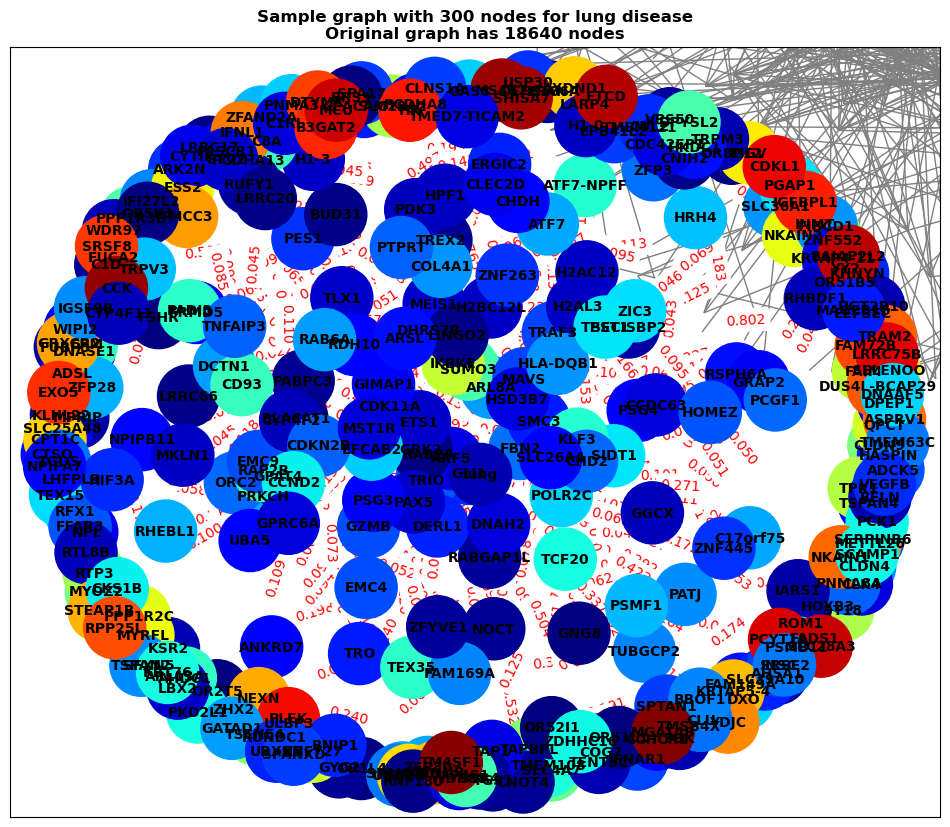

In [5]:
# ---------------------
# GRAPH CREATION
# ---------------------

# Create a bipartite graph using the fetched disease data and PPI
G, positive_edges, negative_edges = BiGraph.create_graph(
    ot_df,
    ppi_df,
    negative_to_positive_ratio=negative_to_positive_ratio,
    output_dir=output_dir
)


# Visualize a sample of the created graph
BiGraph.visualize_sample_graph(G, ot_df, node_size=300, figsize=(12,10), output_dir=output_dir)

In [6]:
# ---------------------
# EMBEDDINGS
# ---------------------

if embedding_mode == "simple_node_embedding":
    # Generate simple node embeddings 
    embeddings = EmbeddingGenerator.simple_node_embedding(G, dim=64)
    disease_name = [d.split()[0] for d in ot_df['disease_name'].unique()][0]
    print(f"\nEmbeddings for node '{disease_name}':\n{embeddings[str(disease_name)]}\n") # Show embeddings for disease node

elif embedding_mode == "Node2Vec":
    # Train Node2Vec model on graph
    n2v_model = Node2Vec(n_components=32, walklen=10)
    print("Training Node2Vec model...")
    embeddings = n2v_model.fit_transform(G)
    node_to_index = map_nodes(G)
    
    disease_name = [d.split()[0] for d in ot_df['disease_name'].unique()][0]
    index = node_to_index[disease_name]
    print(f"\nEmbeddings for node '{disease_name}':\n{embeddings[index]}")
    
    # Save Node2Vec model and vectors
    save_path = output_dir +  disease_name + '/embedding_wheel/'
    os.makedirs(save_path, exist_ok=True)
    n2v_model.save(save_path + 'n2v_model')
    n2v_model.save_vectors(save_path + "n2v_wheel_model.bin")
    
elif embedding_mode == "ProNE":
    # Train ProNE model on graph
    prone_model = ProNE(
        n_components=32,
        step=5,
        mu=0.2,
        theta=0.5,
        exponent=0.75,
        verbose=True
    )
    # Fit model to graph
    print("Training ProNE model...")
    embeddings = prone_model.fit_transform(G)
    node_to_index = map_nodes(G)

    disease_name = [d.split()[0] for d in ot_df['disease_name'].unique()][0]
    index = node_to_index[disease_name]
    print(f"Embeddings for node '{disease_name}':\n{embeddings[index]}")
    
    # Save ProNE model and vectors
    save_path = output_dir +  disease_name + '/embedding_wheel/'
    os.makedirs(save_path, exist_ok=True)
    prone_model.save(save_path + 'prone_model')
    ProNE.save_vectors(prone_model, save_path + "prone_wheel_model.bin")
    print(f"Vectors/model saved to {save_path}")

    
elif embedding_mode == "GGVec":
    # Train GGVec model on graph
    ggvec_model = GGVec(
        n_components=64,       
        order=3,     
        verbose=True 
    )
    print("Training ProNE model...")
    embeddings = ggvec_model.fit_transform(G)
    node_to_index = map_nodes(G)
    
    disease_name = [d.split()[0] for d in ot_df['disease_name'].unique()][0]
    index = node_to_index[disease_name]
    print(f"Embeddings for node '{disease_name}':\n{embeddings[index]}")
    
    # Save GGVec model and vectors
    save_path = output_dir +  disease_name + '/embedding_wheel/'
    os.makedirs(save_path, exist_ok=True)
    ggvec_model.save(save_path + 'ggvec_model')
    GGVec.save_vectors(ggvec_model, save_path + "ggvec_wheel_model.bin")
    print(f"Vectors/model saved to {save_path}")


Training Node2Vec model...
Making walks... Done, T=3.59
Mapping Walk Names... Done, T=1.28
Training W2V... Done, T=209.38

Embeddings for node 'lung':
[-0.31097943 -4.1660657   1.5496684  -1.0685883   2.562408   -2.9975126
 -2.5209763  -0.8388808  -3.6062336  -0.8412157  -4.6320105  -2.2024732
 -4.355687    0.36631376 -4.021329    2.085732    0.76215327  6.9542704
 -1.1137671   0.09638791 -6.113797   -4.667676    6.5994883  -0.04933656
  6.3962965  -1.4965913   1.5549873   5.1001816  -0.55333275 -2.575983
  0.9434795  -5.9954247 ]


In [7]:
# ------------------------------
# FEATURE EXTRACTION AND LABELING
# ------------------------------

# Extract features and labels from edges and embeddings

if embedding_mode == "simple_node_embedding" and not split_edges:
    # Option 1: Directly get feature labels from edges and embeddings (using simple node embedding function)
    X, y = features_labels(positive_edges, negative_edges, embeddings)
    print(f'Sample from X: {X[0:1]}')
    print(f'Sample from y: {y[0:1]}')
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=test_size)

elif embedding_mode == "simple_node_embedding" and split_edges:
    # Option 2: Split edges for prediction, and get features/labels from split edges (using simple node embedding function)
    X, y, edges = features_labels_edges(positive_edges, negative_edges, embeddings, scale_features=False)
    print(f'Sample from X: {X[0:1]}')
    print(f'Sample from y: {y[0:1]}')
    X_train, y_train, X_val, y_val, X_test, y_test, edges_train, edges_val, edges_test = split_edge_data(X, y, edges, test_size=test_size)
    

elif embedding_mode != "simple_node_embedding" and not split_edges:
    # Option 1: Get feature labels using node indexes for advanced embeddings algo (Node2Vec, ProNE, etc.)
    X, y = features_labels_idx(positive_edges, negative_edges, embeddings, node_to_index)
    print(f'Sample from X: {X[0:1]}')
    print(f'Sample from y: {y[0:1]}')
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=test_size)
    
elif embedding_mode != "simple_node_embedding" and split_edges:
    # Option 2: Get feature labels from split edges using node indexes for advanced embeddings algo (Node2Vec, ProNE, etc.)
    X, y, edges = features_labels_edges_idx(positive_edges, negative_edges, embeddings, node_to_index, scale_features=False)
    print(f'Sample from X: {X[0:1]}')
    print(f'Sample from y: {y[0:1]}')
    X_train, y_train, X_val, y_val, X_test, y_test, edges_train, edges_val, edges_test = split_edge_data(X, y, edges, test_size=test_size)

Sample from X: [[ 8.61236155e-01 -6.55511522e+00 -8.31855774e-01  5.21890558e-02
   1.67569840e+00 -5.91884911e-01 -6.37902927e+00 -6.18832707e-01
   5.47733158e-03 -8.73816609e-01 -7.25519061e-01 -1.76219487e+00
   5.87105227e+00 -6.33723438e-01  2.37660551e+00  5.33728790e+00
   1.84228227e-01  2.37836685e+01  7.33176947e-01  1.12808414e-01
   1.06719494e+01 -7.08747530e+00  5.26128721e+00  1.10933542e-01
  -1.32738390e+01  1.49221152e-01 -6.33619055e-02  1.44341218e+00
   9.06589255e-02 -3.27536798e+00  6.15195453e-01  3.40170169e+00]]
Sample from y: [1]


In [8]:
# ------------------------------
# MODEL SELECTION AND PREDICTIONS
# ------------------------------

# OPTION 1: Fit a classifier model based on selected model_name from model_selection file

model_name = model_name 
model, cv_scores= train_model(models[model_name], X_train, y_train, model_name=model_name)
test_results, val_results = validate_model(model, X_test, y_test, X_val, y_val, threshold=0.5)


print(f"\n{model_name} (Test Set)")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")
        
print(f"\n{model_name} (Validation Set):")
for metric, value in val_results.items():
    print(f"{metric}: {value:.4f}")
    
# Save Model
models_path = output_dir + disease_name + '/classifier_models/'
os.makedirs(models_path, exist_ok=True)
joblib.dump(model, models_path + f'{model_name}.pkl')


Logistic_Regression Cross-Validation Results:
Mean F1-score: 0.5531 (+/- 0.0375)

Logistic_Regression (Test Set)
Test Accuracy: 0.8697
Test Precision: 0.4274
Test Recall: 0.8595
Test F1-score: 0.5709
Test ROC-AUC: 0.9453
Test PR-AUC: 0.6856

Logistic_Regression (Validation Set):
Val Accuracy: 0.8727
Val Precision: 0.3789
Val Recall: 0.8485
Val F1-score: 0.5239
Val ROC-AUC: 0.9427
Val PR-AUC: 0.6416


['/home/ahmedsalim/projects/BI-ML_Disease-Prediction_2024/results/lung/classifier_models/Logistic_Regression.pkl']

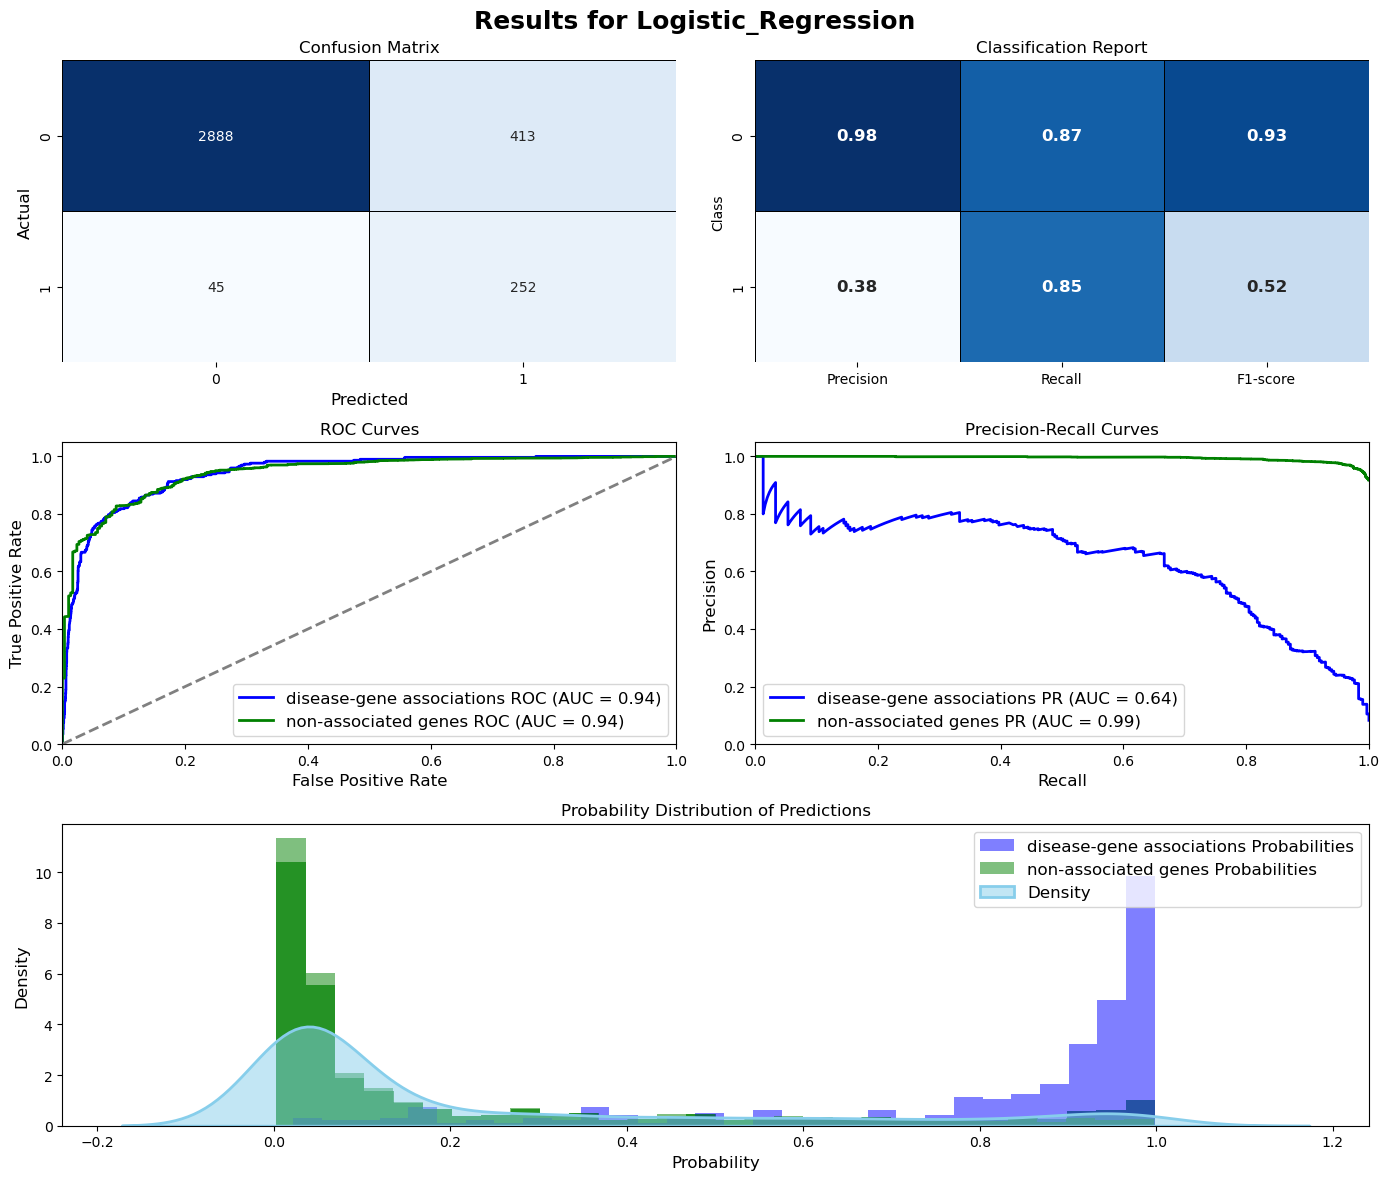

In [9]:
Evaluation = ModelEvaluation(model, X_val, y_val, threshold=0.5, model_name=model_name, figsize=(14,12))
Evaluation.plot_evaluation()

In [10]:
# ----------------------------------
# PREDICTION RESULTS with Confidence
# -----------------------------------
threshold = 0.5

if split_edges:
    associated_proteins, non_associated_proteins = predict(model, X_val, edges_val, threshold=threshold)
    # Print results for associated proteins
    print("\nAssociated Proteins:")
    for i, (edge, (pred, confidence)) in enumerate(associated_proteins.items()):
        if i < 5:
            disease, protein = edge
            print(f"Protein: {protein} (Disease: {disease}), Prediction: {pred}, Confidence Score: {confidence:.4f}")

    # Print results for non-associated proteins
    print("\nNon-Associated Proteins:")
    for j, (edge, (pred, confidence)) in enumerate(non_associated_proteins.items()):
        if j < 5:
            disease, protein = edge
            print(f"Protein: {protein} (Disease: {disease}), Prediction: {pred}, Confidence Score: {confidence:.4f}")
            
    associated_df, non_associated_df = prediction_results(associated_proteins, non_associated_proteins, output_dir=output_dir)
    print(f'\nProteins associated/non-associated to {disease_name} are saved to {output_dir}')


Associated Proteins:
Protein: TAS2R16 (Disease: lung), Prediction: 1, Confidence Score: 0.9775
Protein: CYP4F3 (Disease: lung), Prediction: 1, Confidence Score: 0.5712
Protein: HSD17B12 (Disease: lung), Prediction: 1, Confidence Score: 0.6226
Protein: CSN2 (Disease: lung), Prediction: 1, Confidence Score: 0.9423
Protein: NUP98 (Disease: lung), Prediction: 1, Confidence Score: 0.7276

Non-Associated Proteins:
Protein: WDR75 (Disease: lung), Prediction: 0, Confidence Score: 0.0714
Protein: RPL9 (Disease: lung), Prediction: 0, Confidence Score: 0.0078
Protein: COX5B (Disease: lung), Prediction: 0, Confidence Score: 0.3644
Protein: GEMIN8 (Disease: lung), Prediction: 0, Confidence Score: 0.3405
Protein: RPL26 (Disease: lung), Prediction: 0, Confidence Score: 0.0232

Proteins associated/non-associated to lung are saved to /home/ahmedsalim/projects/BI-ML_Disease-Prediction_2024/results/


In [11]:
associated_df.head()

,disease_name,symbol,prediction,confidence
313,lung,NOTCH1,1,0.998299
31,lung,MET,1,0.997483
18,lung,BMP2,1,0.997302
411,lung,INHBB,1,0.997241
153,lung,SMAD3,1,0.996968


In [12]:
non_associated_df.head()

,disease_name,symbol,prediction,confidence
713,lung,CNOT11,0,0.498954
336,lung,FBXW4,0,0.497719
378,lung,TMEM70,0,0.497098
610,lung,DRAP1,0,0.496080
475,lung,CXCL13,0,0.494857


In [13]:
# OPTION 2: Define your own model and train it, eg; gradient boosting model
gb_model = GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
gb_name = "Gradient Boosting" # Optional

gb_model, gb_cv_scores= train_model(gb_model, X_train, y_train, model_name=gb_name)
gb_test_results, gb_val_results = validate_model(gb_model, X_test, y_test, X_val, y_val, threshold=0.5)

print(f"\n{gb_name} (Test Set):")
for metric, value in gb_test_results.items():
    print(f"{metric}: {value:.4f}")
        
print(f"\n{gb_name} (Validation Set):")
for metric, value in gb_val_results.items():
    print(f"{metric}: {value:.4f}")

# Save Model
joblib.dump(gb_model, models_path + 'gb_classifier.pkl')


Gradient Boosting Cross-Validation Results:
Mean F1-score: 0.6578 (+/- 0.0306)

Gradient Boosting (Test Set):
Test Accuracy: 0.9433
Test Precision: 0.8630
Test Recall: 0.5207
Test F1-score: 0.6495
Test ROC-AUC: 0.9559
Test PR-AUC: 0.7871

Gradient Boosting (Validation Set):
Val Accuracy: 0.9466
Val Precision: 0.7561
Val Recall: 0.5219
Val F1-score: 0.6175
Val ROC-AUC: 0.9422
Val PR-AUC: 0.7103


['/home/ahmedsalim/projects/BI-ML_Disease-Prediction_2024/results/lung/classifier_models/gb_classifier.pkl']

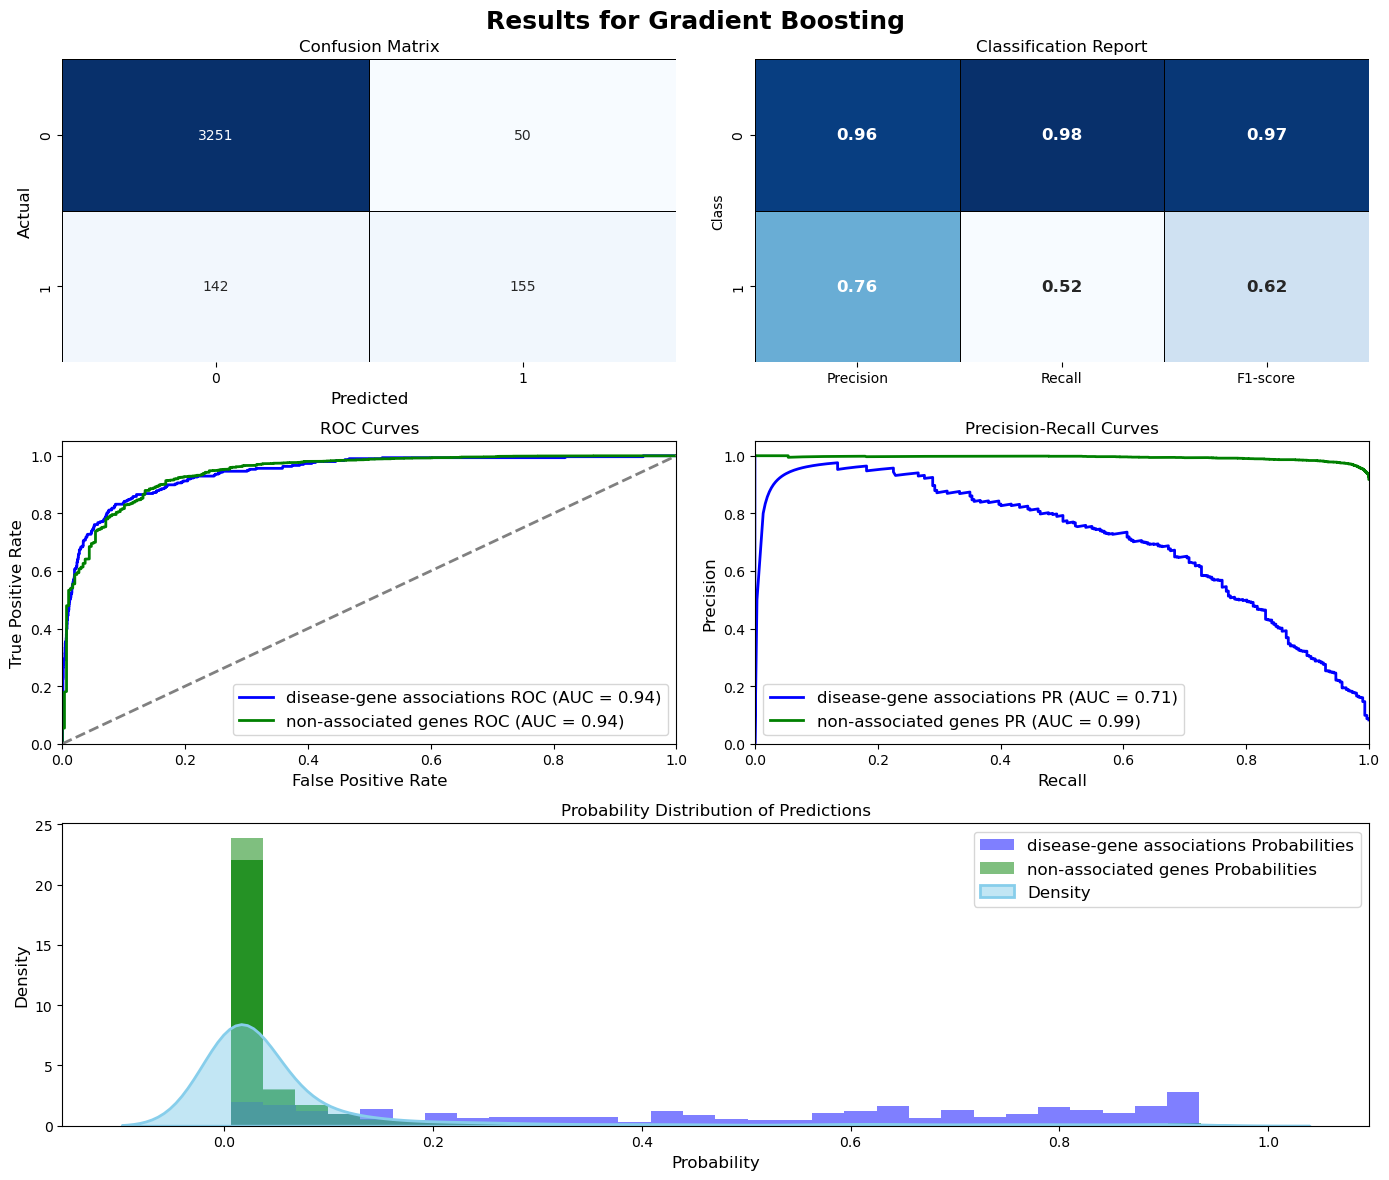

In [14]:
Evaluation = ModelEvaluation(gb_model, X_val, y_val, threshold=0.5, model_name=gb_name, figsize=(14,12))
Evaluation.plot_evaluation()

In [15]:
threshold = 0.5

if split_edges:
    associated_proteins, non_associated_proteins = predict(gb_model, X_val, edges_val, threshold=threshold)    
    associated_df, non_associated_df = prediction_results(associated_proteins, non_associated_proteins)


print(associated_df.head())
print()
print(non_associated_df.head())

    disease_name   symbol  prediction  confidence
27          lung      AGT           1    0.935492
41          lung  SLC17A6           1    0.934275
0           lung  TAS2R16           1    0.930996
183         lung   NDUFS1           1    0.930996
197         lung    SNHG7           1    0.930996

     disease_name    symbol  prediction  confidence
820          lung   GUCY1B1           0    0.497438
970          lung    SRGAP3           0    0.487590
1012         lung  CATSPER1           0    0.478803
1126         lung       MGA           0    0.475078
347          lung    NUTM2B           0    0.474420


In [16]:
# Example of simple dense model using sequential api
tf_model, history, acc, loss = train_tf_model(X_train, y_train, X_test, y_test, X_val, y_val, epochs=70)
print(f'Test Accuracy: {acc}\n Test Loss: {loss}')

# Save model
tf_model.save(models_path + 'tf.keras')

Training sequential API model...
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9550 - loss: 0.1202
Test Accuracy: 0.9555, Test Loss: 0.1173
Test Accuracy: 0.9555432200431824
 Test Loss: 0.11729290336370468


In [17]:
tf_test_results, tf_val_results = validate_model(model, X_test, y_test, X_val, y_val, threshold=0.5, is_tf_model=True)

print("Sequential Model (Test Set):")
for metric, value in gb_test_results.items():
    print(f"{metric}: {value:.4f}")
        
print("\nSequential Model (Validation Set):")
for metric, value in gb_val_results.items():
    print(f"{metric}: {value:.4f}")

Sequential Model (Test Set):
Test Accuracy: 0.9433
Test Precision: 0.8630
Test Recall: 0.5207
Test F1-score: 0.6495
Test ROC-AUC: 0.9559
Test PR-AUC: 0.7871

Sequential Model (Validation Set):
Val Accuracy: 0.9466
Val Precision: 0.7561
Val Recall: 0.5219
Val F1-score: 0.6175
Val ROC-AUC: 0.9422
Val PR-AUC: 0.7103


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


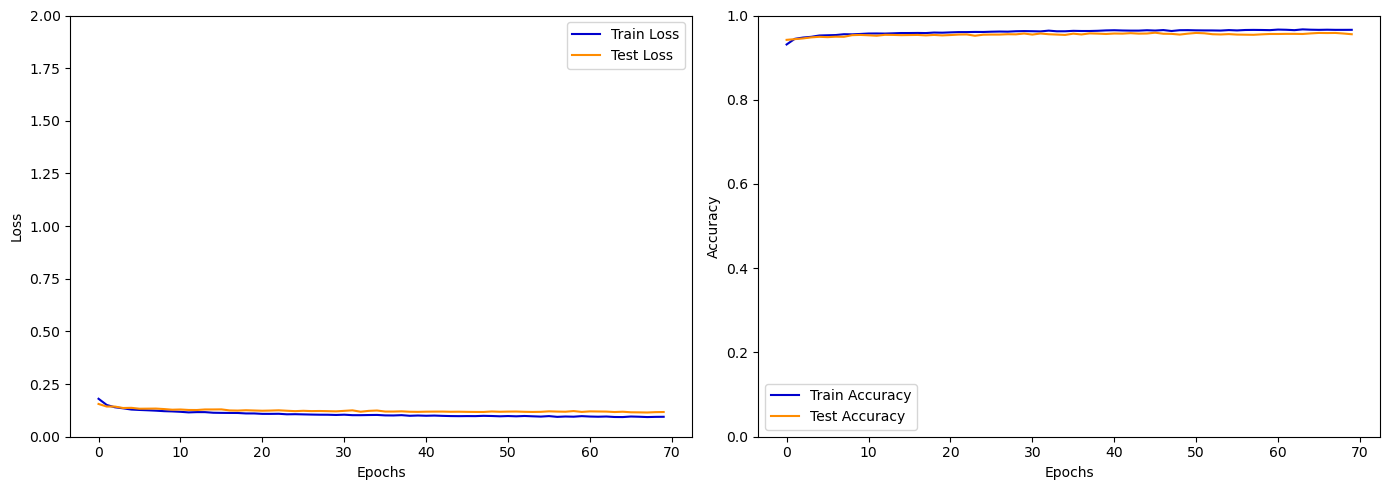

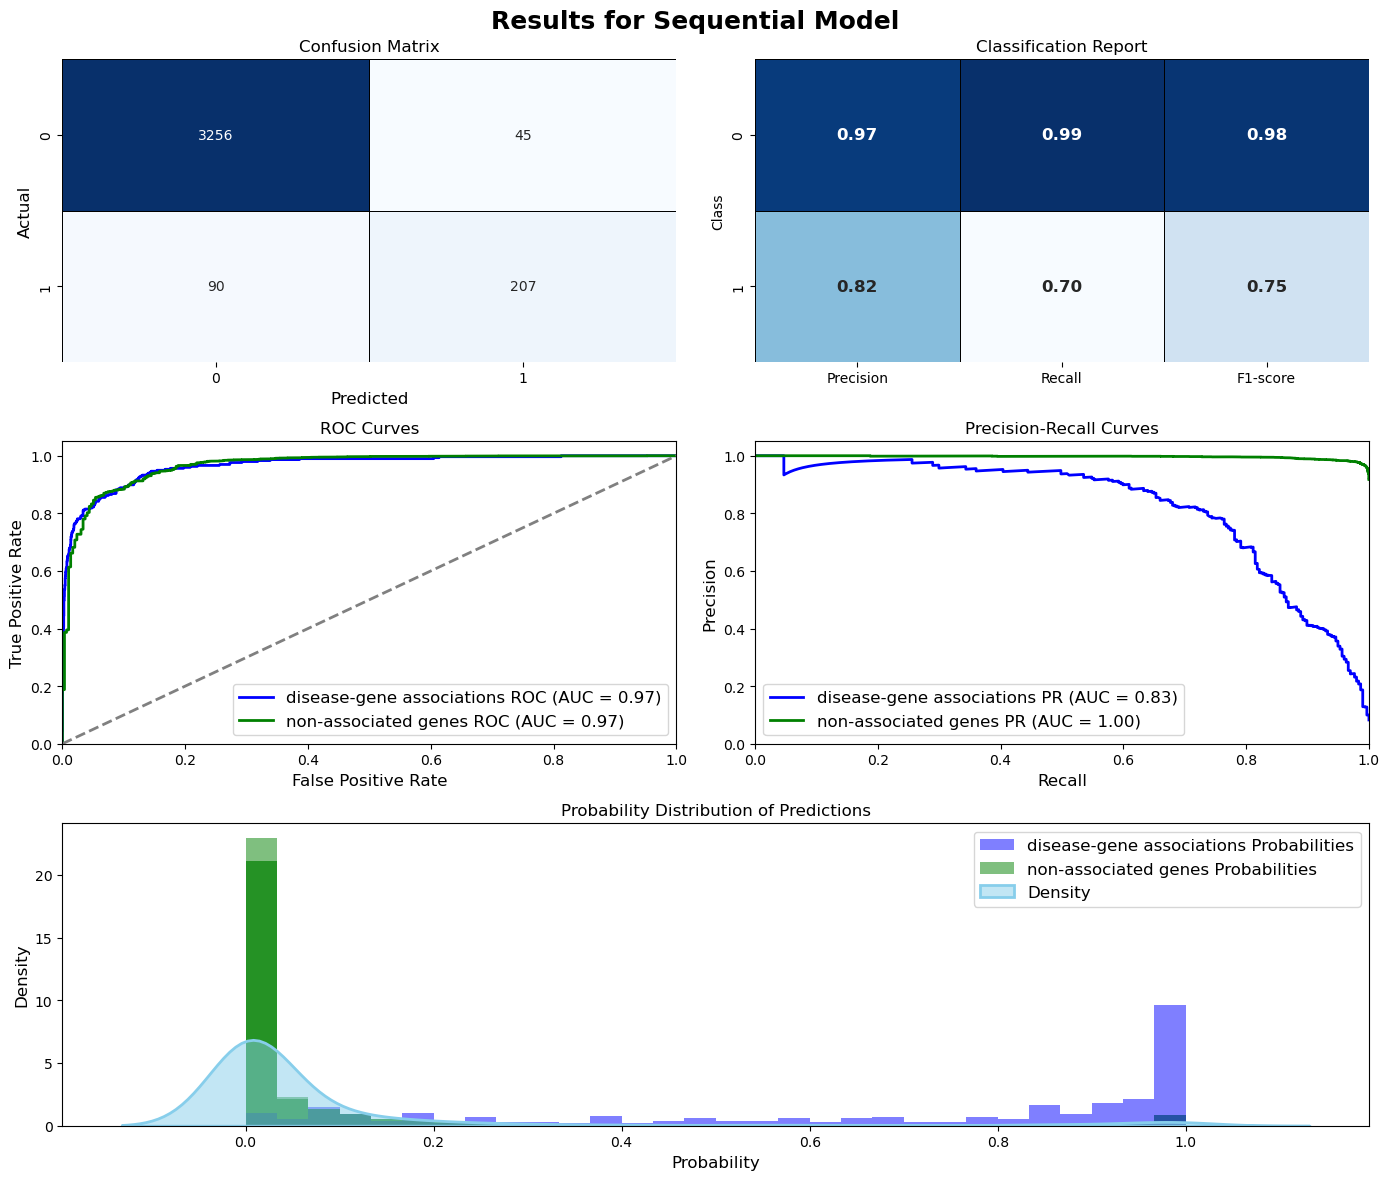

In [18]:
Evaluation = ModelEvaluation(tf_model, X_val, y_val, threshold=0.5, model_name="Sequential Model", figsize=(14,12),
                             is_tf_model=True, history=history, history_figsize=(14, 5))

Evaluation.plot_history()
Evaluation.plot_evaluation()

In [19]:
threshold = 0.5

if split_edges:
    associated_proteins, non_associated_proteins = predict(tf_model, X_val, edges_val, threshold=threshold)    
    associated_df, non_associated_df = prediction_results(associated_proteins, non_associated_proteins)


associated_df

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,disease_name,symbol,prediction,confidence
150,lung,SYCE2,1,0.999978
56,lung,FSHB,1,0.999974
24,lung,MYD88,1,0.999957
60,lung,SLC17A6,1,0.999799
193,lung,CATSPER1,1,0.999791
...,...,...,...,...
113,lung,CFB,1,0.531065
73,lung,CXCR2,1,0.525896
245,lung,VCPKMT,1,0.518479
68,lung,RASSF1,1,0.514025


In [20]:
non_associated_df

,disease_name,symbol,prediction,confidence
529,lung,CCR6,0,4.976931e-01
1022,lung,EXO1,0,4.963719e-01
936,lung,RRM2,0,4.926299e-01
519,lung,NR0B2,0,4.912670e-01
933,lung,XIAP,0,4.745862e-01
...,...,...,...,...
215,lung,MRPL57,0,1.131001e-07
564,lung,MRPS30,0,7.298207e-08
116,lung,SF3B5,0,4.094883e-08
1081,lung,MALSU1,0,1.030114e-09
